In [1]:
import pickle
from gensim.models import word2vec, Word2Vec
import multiprocessing
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KDTree
from sklearn.svm import SVC

%matplotlib inline

/home/kavya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/kavya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kavya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kavya/anaconda3/lib/python3.6/site-packages/

## Load mol2vec Model

In [2]:
with open("./data/mol_sentences.pkl", "rb") as file:
    sentences = pickle.load(file)

In [3]:
w2v = word2vec.Word2Vec.load('../SPVec/model_300dim.pkl')

In [4]:
dimensions = 300

## Load ATC data

In [5]:
with open("./data/mol_sentences.pkl", "rb") as file:
    sentences = pickle.load(file)

In [6]:
atc = [sentence[1][0] for sentence in sentences]
sentences = [sentence[3] for sentence in sentences]

## Vectorisation

In [7]:
vectors = []

for sentence in sentences:
    vector = []
    for word in sentence:
        try:
            vector+=list(w2v.wv.word_vec(word))
        except:
            vector+=([0 for a in range(0, dimensions)])
    vectors.append(vector)
    
vectors = np.asarray(vectors)

In [8]:
sum_vectors = []

for vector in vectors:
    arr = np.asarray(vector)
    arr = arr.reshape((int(arr.shape[0]/dimensions), dimensions) )
    sum_vectors.append(arr.sum(axis=0))

sum_vectors = np.asarray(sum_vectors)

In [9]:
le = LabelEncoder()
le.fit(atc)

atc = le.transform(atc)

## T-SNE

In [10]:
ile = le.inverse_transform(np.asarray(range(0, 14)))

/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [11]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(sum_vectors)

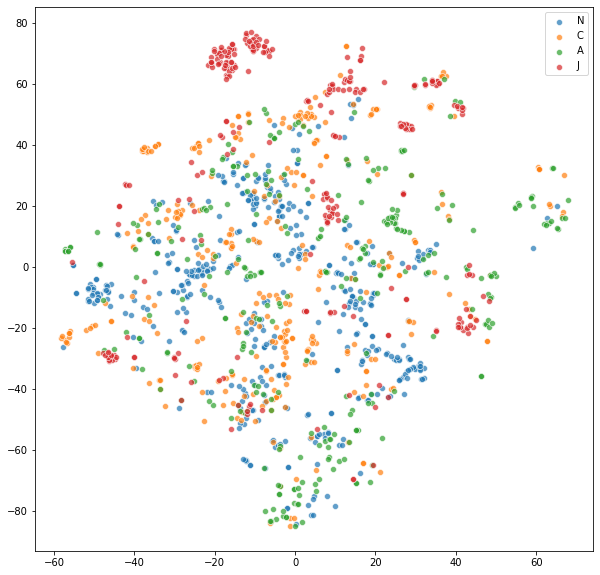

In [12]:
plt.figure(figsize=(10, 10))
top_atc_labels = [a for a,_ in Counter(atc).most_common(4)]
for i in top_atc_labels:
    sns.scatterplot(X_2d[atc == i, 0], X_2d[atc == i, 1], label=ile[i], palette=sns.color_palette("hls", 10), 
                    legend="full", alpha=0.7)

## Data Preparation

In [161]:
X = sum_vectors
y = atc

atc_counter = Counter(y)
top_atc = [a for a, _ in atc_counter.most_common(14)]

temp_x = []
temp_y = []

for i in range(y.shape[0]):
    if y[i] in top_atc:
        temp_x.append(X[i])
        temp_y.append(y[i])
        
X = np.asarray(temp_x)
y = np.asarray(temp_y)

atc_labels = le.inverse_transform(np.unique(y))

/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=int(random.random()*100))

## Helper Functions

In [163]:
def accuracy(y_true, y_pred, atc_labels=atc_labels):
    print("Overall Accuracy:", np.sum(np.equal(y_true, y_pred))/y_true.shape[0])
    matrix = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=True,cbar=False, xticklabels=atc_labels, yticklabels=atc_labels)

## KNN

In [164]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Overall Accuracy: 0.45975609756097563
             precision    recall  f1-score   support

          0       0.32      0.48      0.38        88
          1       0.19      0.15      0.17        27
          2       0.39      0.48      0.43        93
          3       0.36      0.34      0.35        50
          4       0.62      0.36      0.46        55
          5       0.67      0.53      0.59        15
          6       0.63      0.74      0.68        89
          7       0.64      0.43      0.52        67
          8       0.37      0.35      0.36        40
          9       0.50      0.66      0.57       134
         10       0.39      0.24      0.30        29
         11       0.49      0.33      0.40        63
         12       0.08      0.04      0.05        26
         13       0.67      0.32      0.43        44

avg / total       0.47      0.46      0.45       820



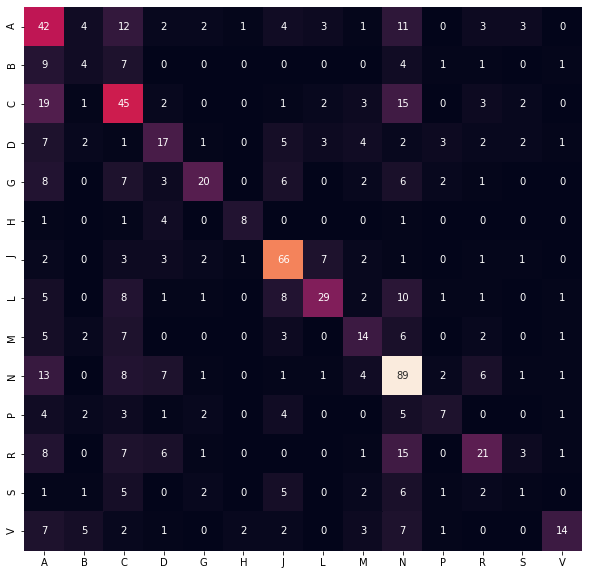

In [165]:
y_pred = neigh.predict(X_test)
accuracy(y_test, y_pred, atc_labels)

## Random Forest

In [166]:
rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion='entropy')
# Fit on training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Overall Accuracy: 0.47073170731707314
             precision    recall  f1-score   support

          0       0.33      0.47      0.39        88
          1       0.18      0.07      0.11        27
          2       0.41      0.49      0.45        93
          3       0.45      0.30      0.36        50
          4       0.65      0.36      0.47        55
          5       0.50      0.27      0.35        15
          6       0.66      0.75      0.71        89
          7       0.71      0.51      0.59        67
          8       0.45      0.23      0.30        40
          9       0.41      0.83      0.55       134
         10       0.83      0.17      0.29        29
         11       0.43      0.16      0.23        63
         12       0.50      0.12      0.19        26
         13       0.73      0.43      0.54        44

avg / total       0.50      0.47      0.45       820



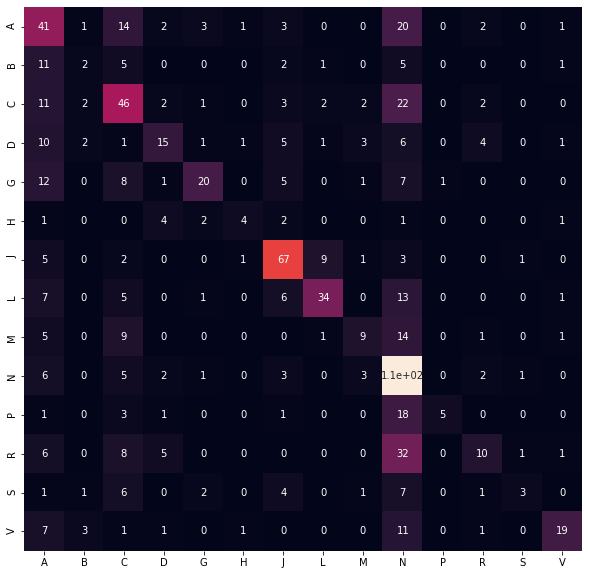

In [167]:
y_pred = rf_model.predict(X_test)
accuracy(y_test, y_pred, atc_labels)

## ANN

In [143]:
oeAtc = OneHotEncoder(sparse=False)
oeAtc.fit(y.reshape(-1, 1))
y_onehot = oeAtc.transform(y.reshape(-1, 1))

X_train, X_test, y_onehot_train, y_onehot_test = train_test_split(X, y_onehot, test_size=0.3, random_state=int(random.random()*100))

In [144]:
class Network:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Dense(50, input_dim=dimensions, activation='relu'))
        self.model.add(Dense(30, activation='relu'))
        self.model.add(Dense(20, activation='relu'))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, X, y, X_test, y_test, epochs=20):
        self.model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test))
    
    def test(self, X, y):
        y_pred = self.model.predict(X).argmax(axis=1)
        y_true = y.argmax(axis=1)
        accuracy(y_true, y_pred)
        

In [145]:
network = Network(len(atc_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 50)                15050     
_________________________________________________________________
dense_18 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_19 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 84        
Total params: 17,284
Trainable params: 17,284
Non-trainable params: 0
_________________________________________________________________
None


In [146]:
network.train(X_train, y_onehot_train, X_test, y_onehot_test, epochs=10)

Train on 991 samples, validate on 425 samples
Epoch 1/10
991/991 [==============================] - 1s 603us/step - loss: 1.5982 - acc: 0.3421 - val_loss: 1.3398 - val_acc: 0.4329
Epoch 2/10
991/991 [==============================] - 0s 86us/step - loss: 1.2182 - acc: 0.4723 - val_loss: 1.1516 - val_acc: 0.5176
Epoch 3/10
991/991 [==============================] - 0s 88us/step - loss: 1.0928 - acc: 0.5358 - val_loss: 1.1581 - val_acc: 0.4918
Epoch 4/10
991/991 [==============================] - 0s 78us/step - loss: 1.0292 - acc: 0.5812 - val_loss: 1.1566 - val_acc: 0.5224
Epoch 5/10
991/991 [==============================] - 0s 80us/step - loss: 1.0100 - acc: 0.5802 - val_loss: 1.1392 - val_acc: 0.5341
Epoch 6/10
991/991 [==============================] - 0s 88us/step - loss: 0.9255 - acc: 0.6276 - val_loss: 1.0250 - val_acc: 0.5647
Epoch 7/10
991/991 [==============================] - 0s 98us/step - loss: 0.9057 - acc: 0.6367 - val_loss: 1.0664 - val_acc: 0.5341
Epoch 8/10
991/991 [==

Overall Accuracy: 0.6094117647058823
             precision    recall  f1-score   support

          0       0.39      0.42      0.40        76
          1       0.52      0.65      0.58       105
          2       0.78      0.67      0.72        91
          3       0.73      0.64      0.68       153

avg / total       0.63      0.61      0.62       425



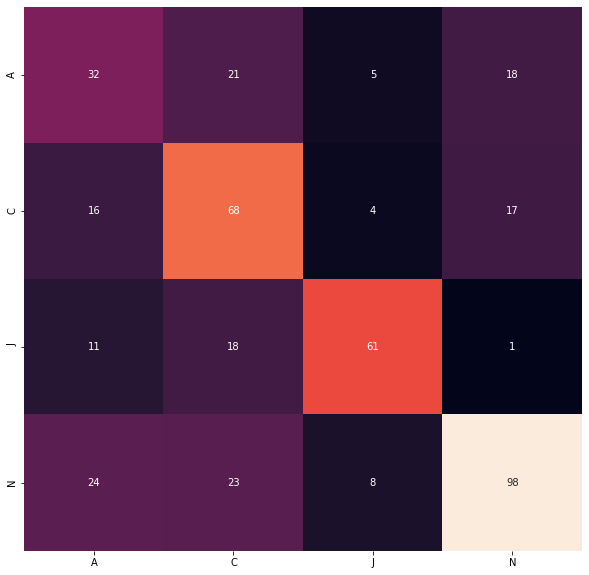

In [147]:
s = network.test(X_test, y_onehot_test)

## SVM

In [59]:
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Overall Accuracy: 0.4350453172205438
             precision    recall  f1-score   support

          2       0.34      0.11      0.16       102
          6       0.29      0.07      0.12        82
          9       0.46      0.86      0.60       147

avg / total       0.38      0.44      0.34       331



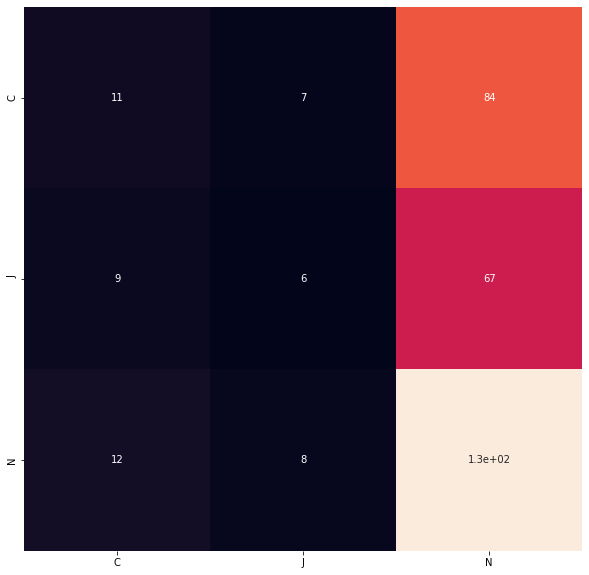

In [63]:
y_pred = clf.predict(X_test)
accuracy(y_test, y_pred, atc_labels)

## CNN RNN

In [86]:
with open("./data/mol_sentences.pkl", "rb") as file:
    sentences = pickle.load(file)

In [87]:
atc = [sentence[1][0] for sentence in sentences]
sentences = [sentence[3] for sentence in sentences]

In [258]:
vectors = []
max_identifiers = 300

for sentence in sentences[:1000]:
    vector = np.zeros(max_identifiers*dimensions)
    if len(sentence)>max_identifiers:
        continue
    for word in sentence:
        try:
            we = w2v.wv.word_vec(word)
            vector[:we.shape[0],:we.shape[1]] = we
            
        except:
            pass
    vectors.append(vector)
    
vectors = np.asarray(vectors).reshape(len(vectors), max_identifiers*dimensions)

In [259]:
vectors.shape

(1000, 90000)

In [260]:
le = LabelEncoder()
le.fit(atc)

atc = le.transform(atc)

In [261]:
Long_X = vectors
oeAtc = OneHotEncoder(sparse=False)
oeAtc.fit(y.reshape(-1, 1))
y_onehot = oeAtc.transform(y[:1000].reshape(-1, 1))

X_train, X_test, y_onehot_train, y_onehot_test = train_test_split(Long_X, y_onehot, test_size=0.3, 
                                                                  random_state=int(random.random()*100))

In [265]:
class Network:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Reshape((max_identifiers, dimensions), input_shape=(max_identifiers*dimensions, )))
        self.model.add(Conv1D(192, 5, activation='relu'))
        self.model.add(MaxPool1D(5))
#         self.model.add(BatchNormalization())        
#         self.model.add(Conv1D(192, 5, activation='relu'))
        self.model.add(Conv1D(140, 3, activation='relu'))
#         self.model.add(LSTM(70, dropout=0.7, recurrent_dropout=0.2, activation='selu', return_sequences=True,))
#         self.model.add(LSTM(70, dropout=0.4, recurrent_dropout=0.2, activation='relu'))
        self.model.add(Flatten())
#         self.model.add(Dense(100, activation='relu'))
        self.model.add(Dropout(rate=0.9))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, X, y, X_test, y_test, epochs=20):
        self.model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test))
    
    def test(self, X, y):
        y_pred = self.model.predict(X).argmax(axis=1)
        y_true = y.argmax(axis=1)
        accuracy(y_true, y_pred)
        

In [266]:
network = Network(len(atc_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 296, 192)          288192    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 59, 192)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 57, 140)           80780     
_________________________________________________________________
flatten_5 (Flatten)          (None, 7980)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7980)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 31924     
Total para

In [267]:
network.train(X_train, y_onehot_train, X_test, y_onehot_test, epochs=10)

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 8s 12ms/step - loss: 1.3855 - acc: 0.3057 - val_loss: 1.3831 - val_acc: 0.3967
Epoch 2/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3839 - acc: 0.3214 - val_loss: 1.3802 - val_acc: 0.3967
Epoch 3/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3827 - acc: 0.3214 - val_loss: 1.3775 - val_acc: 0.3967
Epoch 4/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3814 - acc: 0.3214 - val_loss: 1.3754 - val_acc: 0.3967
Epoch 5/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3804 - acc: 0.3214 - val_loss: 1.3737 - val_acc: 0.3967
Epoch 6/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3795 - acc: 0.3214 - val_loss: 1.3717 - val_acc: 0.3967
Epoch 7/10
700/700 [==============================] - 6s 9ms/step - loss: 1.3787 - acc: 0.3214 - val_loss: 1.3699 - val_acc: 0.3967
Epoch 8/10
700/700 [=========

Overall Accuracy: 0.39666666666666667


/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        57
          1       0.00      0.00      0.00        56
          2       0.00      0.00      0.00        68
          3       0.40      1.00      0.57       119

avg / total       0.16      0.40      0.23       300



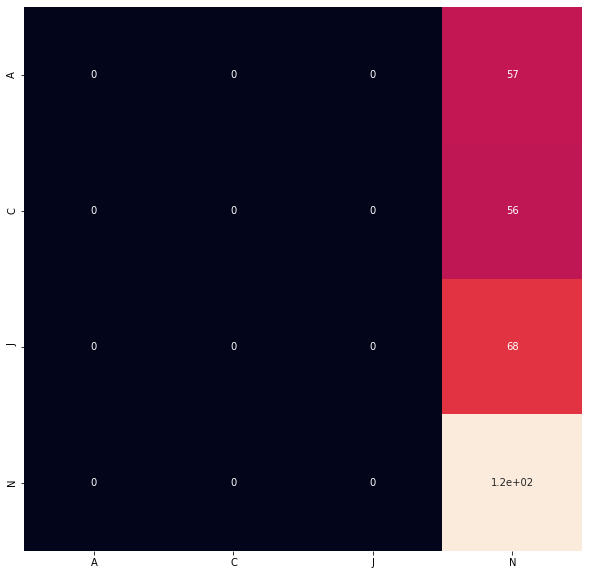

In [268]:
s = network.test(X_test, y_onehot_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])